### Задача

С раннего детства я являюсь футбольным болельщиком. Меня всегда интересовали результаты игр и мне хотелось предсказывать какая команда победит или проиграет.  
Именно поэтому я решил провести эксперимент и узнать, смогу ли я предсказывтаь победы команд.  
Для этого я проанализирую набор данных о ```EPL``` за 1993-2021 года.

### Описание данных

Данные представляют собой практически все футбольные аспкеты, которые могут произойти за 90-минутную игру.  

Для определения победителя ```EPL``` нужно выполнить классификацию признака ```FTR```, которая является результатом игры футбольных команд (победа, ничья, поражение).

|Column|	Description|
|-|-|
|Season|	Match Season|
|DateTime|	Match Date and Time (yyyy-mm-dd hh:mm:ss)|
|HomeTeam|	Home Team|
|AwayTeam|	Away Team|
|FTHG|	Full Time Home Team Goals|
|FTAG|	Full Time Away Team Goals|
|FTR|	Full Time Result (H=Home Win, D=Draw, A=Away Win)|
|HTHG|	Half Time Home Team Goals|
|HTAG|	Half Time Away Team Goals|
|HTR|	Half Time Result (H=Home Win, D=Draw, A=Away Win)|
|Referee|	Match Referee|
|HS|Home Team Shots|
|AS|Away Team Shots|
|HST|	Home Team Shots on Target|
|AST|	Away Team Shots on Target|
|HC|	Home Team Corners|
|AC|	Away Team Corners|
|HF|	Home Team Fouls Committed|
|AF|	Away Team Fouls Committed|
|HY|	Home Team Yellow Cards|
|AY|	Away Team Yellow Cards|
|HR|	Home Team Red Cards|
|AR|	Away Team Red Cards|

### Обработка данных

In [401]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier as KNN

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

Какие данные мы будем обрабатывать и общая информация о датасете

In [402]:
table = pd.read_csv('./premier-league.csv', encoding = 'ISO-8859-1')
table.tail()

,Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
11108,2021-22,2022-04-09T17:30:00Z,Aston Villa,Tottenham,0,4,A,0.0,1.0,A,...,8.0,5.0,9.0,3.0,12.0,14.0,2.0,3.0,0.0,0.0
11109,2021-22,2022-04-10T14:00:00Z,Brentford,West Ham,2,0,H,0.0,0.0,D,...,7.0,1.0,4.0,6.0,2.0,6.0,0.0,1.0,0.0,0.0
11110,2021-22,2022-04-10T14:00:00Z,Leicester,Crystal Palace,2,1,H,2.0,0.0,H,...,3.0,3.0,3.0,4.0,11.0,12.0,1.0,1.0,0.0,0.0
11111,2021-22,2022-04-10T14:00:00Z,Norwich,Burnley,2,0,H,1.0,0.0,H,...,6.0,4.0,6.0,7.0,12.0,10.0,1.0,1.0,0.0,0.0
11112,2021-22,2022-04-10T16:30:00Z,Man City,Liverpool,2,2,D,2.0,1.0,H,...,5.0,4.0,4.0,1.0,9.0,11.0,1.0,4.0,0.0,0.0


In [403]:
print(table.info(verbose=False))
print(f'shape: {table.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11113 entries, 0 to 11112
Columns: 23 entries, Season to AR
dtypes: float64(14), int64(2), object(7)
memory usage: 2.0+ MB
None
shape: (11113, 23)


В нашем датасете есть несколько ненужных признаков, поэтому перед обработкой данных необходимо удалить признаки, не имеющие для нас никакой ценности.

In [404]:
table.drop(['Season', 'Referee'], axis=1, inplace=True)
table.reset_index(drop=True, inplace=True)

table['FTR'].value_counts()

H    5088
A    3161
D    2864
Name: FTR, dtype: int64

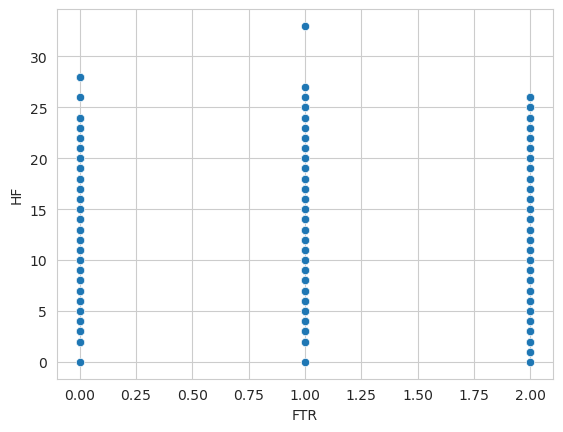

In [405]:
LE = LabelEncoder()

LE.fit(table['FTR'])
table['FTR'] = LE.transform(table['FTR'])

sns.scatterplot(data=table, x='FTR', y='HF');

### Заполнение пропущенных значений

Пропущенные значения в таблице записываются как ```NaN```.  
Проанализируем, как много пропущенных значений есть в каждом столбце датасета.

In [406]:
table.isna().sum()

DateTime       0
HomeTeam       0
AwayTeam       0
FTHG           0
FTAG           0
FTR            0
HTHG         924
HTAG         924
HTR          924
HS          2824
AS          2824
HST         2824
AST         2824
HC          2824
AC          2824
HF          2824
AF          2824
HY          2824
AY          2824
HR          2824
AR          2824
dtype: int64

Заполним пропущенные значения ```медианами```, которые соответствуют числовым признакам.  
Помимо этого у нас есть один категориальный признак: ```HTR``` - заполним его ```модой```.

In [407]:
table.fillna(table.median(axis=0, numeric_only=True), axis=0 , inplace=True)
table['HTR'].fillna(table['HTR'].mode().iloc[0], inplace=True)

In [408]:
table.isna().sum()

DateTime    0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
HS          0
AS          0
HST         0
AST         0
HC          0
AC          0
HF          0
AF          0
HY          0
AY          0
HR          0
AR          0
dtype: int64

### Работа с выбросами

In [409]:
table['HF'].tail()

11108    12.0
11109     2.0
11110    11.0
11111    12.0
11112     9.0
Name: HF, dtype: float64

In [410]:
table['HF'].quantile([0.005, 0.5, 0.995])

0.005     3.0
0.500    11.0
0.995    22.0
Name: HF, dtype: float64

Удалим обьекты, которые выходят за пределы квантилей 0.005 и 0.995

In [411]:
drop_table = table[(table['HF'] < table['HF'].quantile(0.005)) | (table['HF'] > table['HF'].quantile(0.995))].index
table = table.drop(drop_table)
print(table.shape)

(11037, 21)


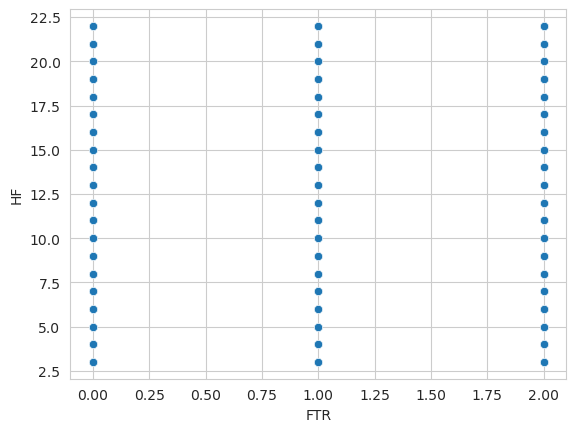

In [412]:
sns.scatterplot(data=table, x='FTR', y='HF');

### Визуализация данных и описательная статистика

In [413]:
table.describe()

,FTHG,FTAG,FTR,HTHG,HTAG,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
count,11037.000000,11037.000000,11037.000000,11037.000000,11037.000000,11037.000000,11037.000000,11037.000000,11037.000000,11037.000000,11037.000000,11037.000000,11037.000000,11037.000000,11037.000000,11037.000000,11037.000000
mean,1.518982,1.141343,1.172964,0.627163,0.459183,13.383981,10.481743,6.088792,4.568995,6.062336,4.584036,11.241732,11.896258,1.306605,1.810456,0.045846,0.066322
std,1.302383,1.134787,0.843864,0.822547,0.704980,4.544140,3.960451,2.873038,2.424106,2.671129,2.379181,3.122906,3.396081,1.038688,1.098513,0.218068,0.258500
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,11.000000,8.000000,4.000000,3.000000,5.000000,3.000000,10.000000,10.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,13.000000,10.000000,6.000000,4.000000,6.000000,4.000000,11.000000,12.000000,1.000000,2.000000,0.000000,0.000000
75%,2.000000,2.000000,2.000000,1.000000,1.000000,15.000000,12.000000,7.000000,6.000000,7.000000,6.000000,13.000000,13.000000,2.000000,2.000000,0.000000,0.000000
max,9.000000,9.000000,2.000000,5.000000,5.000000,43.000000,30.000000,24.000000,20.000000,20.000000,19.000000,22.000000,28.000000,7.000000,9.000000,3.000000,2.000000


Несбалансированность классов

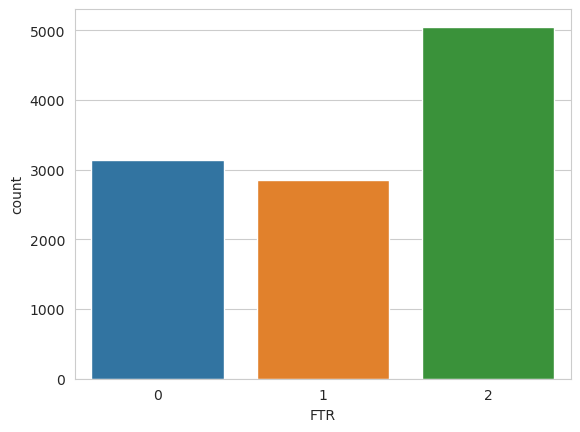

In [414]:
sns.countplot(x='FTR', data=table);

Text(0.5, 1.0, 'Игры всех команд EPL')

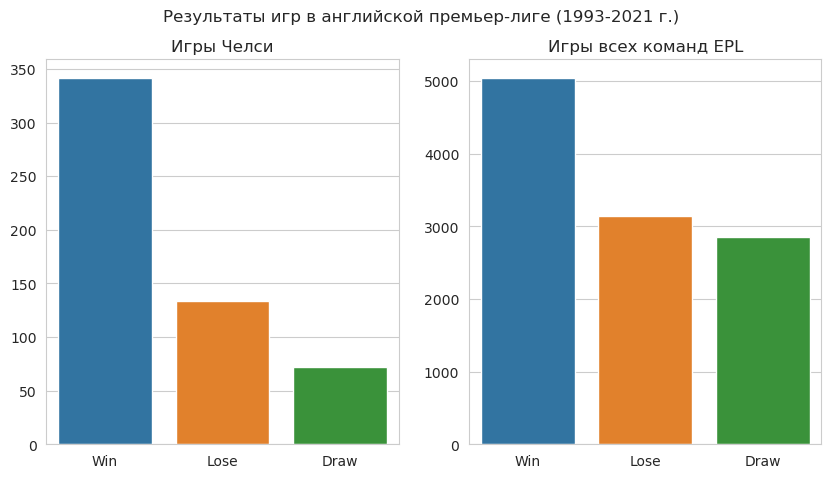

In [415]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 5))
fig.suptitle('Результаты игр в английской премьер-лиге (1993-2021 г.)')

table_demo = table['FTR'].replace({0: 'Lose', 1: 'Draw', 2: 'Win'})

all_ftr = table_demo.value_counts()
arcenal_ftr = table_demo[table.HomeTeam == 'Chelsea'].value_counts()

sns.barplot(ax=axes[0], x=arcenal_ftr.index, y=arcenal_ftr.values)
axes[0].set_title('Игры Челси')

# Всего сыграно игр
sns.barplot(ax=axes[1], x=all_ftr.index, y=all_ftr.values)
axes[1].set_title('Игры всех команд EPL')

Вычислим матрицу корреляции для количественных признаков

In [416]:
corr = table.corr(numeric_only=True)
corr

,FTHG,FTAG,FTR,HTHG,HTAG,HS,AS,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
FTHG,1.000000,-0.055278,0.619532,0.648558,-0.024495,0.245180,-0.115600,0.369236,-0.087028,0.026462,-0.059842,-0.062016,-0.031176,-0.100892,-0.001032,-0.065917,0.072698
FTAG,-0.055278,1.000000,-0.626489,-0.038673,0.642971,-0.111811,0.279251,-0.103487,0.386892,-0.066790,0.042318,0.003935,-0.028971,0.098377,-0.025246,0.103436,-0.056980
FTR,0.619532,-0.626489,1.000000,0.404390,-0.398236,0.188591,-0.215020,0.271992,-0.267956,0.042370,-0.033710,-0.030240,0.021375,-0.114989,0.021098,-0.113509,0.081994
HTHG,0.648558,-0.038673,0.404390,1.000000,0.014460,0.111711,-0.020489,0.223401,-0.020749,-0.043035,0.027564,-0.008969,-0.024357,-0.056775,-0.010828,-0.013308,0.047694
HTAG,-0.024495,0.642971,-0.398236,0.014460,1.000000,-0.039967,0.163065,-0.061424,0.264971,-0.018089,0.000708,-0.006219,-0.003945,0.105446,-0.021224,0.077009,-0.005033
HS,0.245180,-0.111811,0.188591,0.111711,-0.039967,1.000000,-0.325435,0.681500,-0.226373,0.473688,-0.269090,-0.154641,-0.028820,-0.098953,0.019573,-0.098693,0.100275
AS,-0.115600,0.279251,-0.215020,-0.020489,0.163065,-0.325435,1.000000,-0.255748,0.693162,-0.307931,0.473166,0.027222,-0.122043,0.123568,-0.078066,0.117534,-0.093167
HST,0.369236,-0.103487,0.271992,0.223401,-0.061424,0.681500,-0.255748,1.000000,-0.035136,0.355518,-0.161479,-0.061402,0.028619,-0.135287,0.007888,-0.067387,0.088212
AST,-0.087028,0.386892,-0.267956,-0.020749,0.264971,-0.226373,0.693162,-0.035136,1.000000,-0.171321,0.358518,0.070476,-0.040752,0.086281,-0.059129,0.118976,-0.051551
HC,0.026462,-0.066790,0.042370,-0.043035,-0.018089,0.473688,-0.307931,0.355518,-0.171321,1.000000,-0.234346,-0.083168,0.009703,-0.054180,0.029905,-0.056709,0.048079


Построим тепловую карту

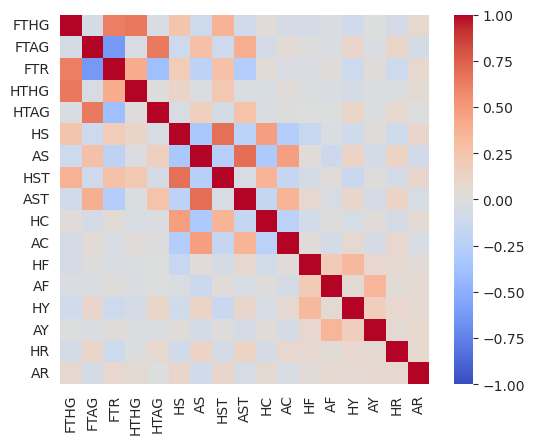

In [417]:
sns.heatmap(corr, square=True, cmap='coolwarm', vmin = -1, vmax = 1);

Определим коррелирующие между собой признаки

In [418]:
corr.where(np.triu(corr > 0.65, k=1)).stack()

HS  HST    0.681500
AS  AST    0.693162
dtype: float64

### Обработка категориальных признаков

Преобразуем тип данных ```DateTime``` в дни недели когда были сыграны игры между командами

In [419]:
table['MatchDate'] = pd.to_datetime(table['DateTime'], infer_datetime_format=True)
table['MatchDay'] = table['MatchDate'].dt.day_name()

table.drop('DateTime', axis=1, inplace=True)
table.drop('MatchDate', axis=1, inplace=True)

table = pd.get_dummies(table, 
                       columns=['HomeTeam', 'AwayTeam', 'HTR', 'MatchDay'],
                       prefix = ['HomeTeam', 'AwayTeam', 'HTR', 'MatchDay']
)

table

,FTHG,FTAG,FTR,HTHG,HTAG,HS,AS,HST,AST,HC,...,HTR_A,HTR_D,HTR_H,MatchDay_Friday,MatchDay_Monday,MatchDay_Saturday,MatchDay_Sunday,MatchDay_Thursday,MatchDay_Tuesday,MatchDay_Wednesday
0,0,3,0,0.0,0.0,13.0,10.0,6.0,4.0,6.0,...,0,1,0,0,0,1,0,0,0,0
1,4,1,2,0.0,0.0,13.0,10.0,6.0,4.0,6.0,...,0,1,0,0,0,1,0,0,0,0
2,1,2,0,0.0,0.0,13.0,10.0,6.0,4.0,6.0,...,0,1,0,0,0,1,0,0,0,0
3,2,0,2,0.0,0.0,13.0,10.0,6.0,4.0,6.0,...,0,1,0,0,0,1,0,0,0,0
4,1,1,1,0.0,0.0,13.0,10.0,6.0,4.0,6.0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11107,0,3,0,0.0,1.0,8.0,10.0,1.0,5.0,3.0,...,1,0,0,0,0,1,0,0,0,0
11108,0,4,0,0.0,1.0,9.0,11.0,8.0,5.0,9.0,...,1,0,0,0,0,1,0,0,0,0
11110,2,1,2,2.0,0.0,12.0,11.0,3.0,3.0,3.0,...,0,0,1,0,0,0,1,0,0,0
11111,2,0,2,1.0,0.0,17.0,18.0,6.0,4.0,6.0,...,0,0,1,0,0,0,1,0,0,0


### Обучающая и тестовая выборки

In [420]:
x = pd.concat([table.iloc[:, :2], table.iloc[:, 3:]], axis=1)
y = np.ravel(table['FTR'])

### Нормализация признаков

In [421]:
x_std = (x - x.mean(axis=0)) / x.std(axis=0)
x_std.describe()

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HC,AC,...,HTR_A,HTR_D,HTR_H,MatchDay_Friday,MatchDay_Monday,MatchDay_Saturday,MatchDay_Sunday,MatchDay_Thursday,MatchDay_Tuesday,MatchDay_Wednesday
count,1.103700e+04,1.103700e+04,1.103700e+04,1.103700e+04,1.103700e+04,1.103700e+04,1.103700e+04,1.103700e+04,1.103700e+04,1.103700e+04,...,1.103700e+04,1.103700e+04,1.103700e+04,1.103700e+04,1.103700e+04,1.103700e+04,1.103700e+04,1.103700e+04,1.103700e+04,1.103700e+04
mean,-6.437825e-17,8.497929e-17,-3.605182e-17,-5.150260e-17,1.905596e-16,4.120208e-17,1.442073e-16,-1.236062e-16,9.270468e-17,-3.090156e-17,...,4.635234e-17,-3.090156e-17,1.004301e-16,-3.090156e-17,1.545078e-17,1.133057e-16,-5.150260e-17,2.575130e-17,7.725390e-18,-4.120208e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.166310e+00,-1.005777e+00,-7.624648e-01,-6.513412e-01,-2.945327e+00,-2.646603e+00,-2.119287e+00,-1.884817e+00,-2.269578e+00,-1.926728e+00,...,-5.207939e-01,-9.332289e-01,-6.877005e-01,-1.083161e-01,-2.670934e-01,-1.164991e+00,-4.941096e-01,-1.030571e-01,-2.298754e-01,-3.126710e-01
25%,-3.984862e-01,-1.005777e+00,-7.624648e-01,-6.513412e-01,-5.246275e-01,-6.266314e-01,-7.270326e-01,-6.472471e-01,-3.977103e-01,-6.657902e-01,...,-5.207939e-01,-9.332289e-01,-6.877005e-01,-1.083161e-01,-2.670934e-01,-1.164991e+00,-4.941096e-01,-1.030571e-01,-2.298754e-01,-3.126710e-01
50%,-3.984862e-01,-1.245545e-01,-7.624648e-01,-6.513412e-01,-8.450029e-02,-1.216385e-01,-3.090535e-02,-2.347238e-01,-2.333686e-02,-2.454775e-01,...,-5.207939e-01,-9.332289e-01,-6.877005e-01,-1.083161e-01,-2.670934e-01,8.582983e-01,-4.941096e-01,-1.030571e-01,-2.298754e-01,-3.126710e-01
75%,3.693372e-01,7.566685e-01,4.532711e-01,7.671381e-01,3.556270e-01,3.833545e-01,3.171583e-01,5.903228e-01,3.510366e-01,5.951478e-01,...,-5.207939e-01,1.071451e+00,1.453990e+00,-1.083161e-01,-2.670934e-01,8.582983e-01,-4.941096e-01,-1.030571e-01,-2.298754e-01,-3.126710e-01
max,5.744101e+00,6.925229e+00,5.316215e+00,6.441055e+00,6.517409e+00,4.928291e+00,6.234240e+00,6.365649e+00,5.217892e+00,6.059213e+00,...,1.919971e+00,1.071451e+00,1.453990e+00,9.231405e+00,3.743669e+00,8.582983e-01,2.023659e+00,9.702475e+00,4.349789e+00,3.197960e+00


In [422]:
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size=0.2, shuffle=False, random_state=42)

### KNN и получившиеся оценки

In [423]:
for n in [1, 2, 5, 10, 15, 24]:
    kn_clf_n = KNN(n_neighbors=n)
    kn_clf_n.fit(x_train, y_train)

    y_pred_test_n = kn_clf_n.predict(x_test)
    y_pred_train_n = kn_clf_n.predict(x_train)
    
    print(f"f1_score for {n} neighbors  test = {f1_score(y_test, y_pred_test_n,  average='macro')}")
    print(f"f1_score for {n} neighbors  train = {f1_score(y_train, y_pred_train_n,  average='macro')}")
    print()

f1_score for 1 neighbors  test = 0.4938329696615082
f1_score for 1 neighbors  train = 1.0

f1_score for 2 neighbors  test = 0.4837377797411435
f1_score for 2 neighbors  train = 0.7629362101776452

f1_score for 5 neighbors  test = 0.5144529165710536
f1_score for 5 neighbors  train = 0.6656336727735006

f1_score for 10 neighbors  test = 0.521851394310188
f1_score for 10 neighbors  train = 0.6318381270399679

f1_score for 15 neighbors  test = 0.5134057631658098
f1_score for 15 neighbors  train = 0.608287784036822

f1_score for 24 neighbors  test = 0.5227393843517216
f1_score for 24 neighbors  train = 0.5987688409936788



### Выводы

Как и следовало ожидать, результат оказался удовлетворительный.  
Полученные ```50-60%``` могут говорить о многом, например, о недостаточно большой выборке данных, малом количестве признаков и тд.

Метод ```KNN``` недостаточно качественно может предсказать исход игры команд. Стоит использовать другой метод.

### Спасибо за внимание